The goal of this file is to explain and justify the choices made for the ML 

## Importation 
Let's first import what we need.

In [158]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error, max_error, explained_variance_score


## Data : import and pre-processing

This subsection will read our data file which is currently a .CSV containing all our data.

CSV file look like : [[[altitude1, mach1, rad1], [heatlfux1]], [[altitude2, mach2, rad2], [heatflux2], [altitude3...]]]

We create 2 arrays
- input array x : 
- ouput array y : 


In [159]:
read_file = open('/Users/jeannelonglune/Desktop/memoire/pyCabaret/src/storage_MLdata/ML1000.csv', 'r')

data_list = []
for line in read_file:
    data = line.split(', ')
    data_list.append([[float(data[0]), float(data[1]), float(data[2])], [float(data[3])]])

# creation of the array
x = np.array([item[0] for item in data_list])  # Input : altitude, Mach, rad
y = np.array([item[1] for item in data_list])  # output : heatflux

Data split into : 
- training data (70%)
- validation data (15%)
- test data (15%) (in opposition to the validation set, the test data is not used during the training and so it enable an unbiased model evalutation)

note : random_state is a pseudo-random number parameter that allows you to reproduce the same train test split each time you run the code

In [160]:
# 1st split
X_train, X_val, y_train, y_val = train_test_split(
    x, y, test_size=0.3, random_state=42)
# 2nd split
X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size=0.5, random_state=42)

Scaling - Standardize features :

It's a good practice to scale input features and target variables, in order for the ML model to interpret the input with the same scale.

An explanation of some of the most common scaling techniques and a justification of the choice made can be found in the the folder 'justif' as 'scalingjust.txt'

In [161]:
#scaling - Standardize features
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_val_scaled = x_scaler.transform(X_val)
X_test_scaled = x_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.transform(y_val)
y_test_scaled = y_scaler.transform(y_test)

## Grid search ##

In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
import time


# Define the MLPRegressor model
mlp = MLPRegressor()

# Define the hyperparameter grid including variations in hidden layers, neurons, and loss function
param_grid = {
    'hidden_layer_sizes': [(32,), (64,), (64, 32), (32, 64), (64, 32, 32), (32, 32, 64), (32, 32, 32, 64), (64, 32, 32, 32, 32)],
    'activation': ['relu', 'tanh', 'linear'],
    'alpha': [0.0001, 0.001, 0.01],  # amount of regularization applied to the neural network's weights during training
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.0005, 0.001, 0.004, 0.005, 0.006, 0.007, 0.008, 0.01, 0.011, 0.1, 0.0065, 0.0055],  # Numeric values for initial learning rates
    'solver': ['lbfgs', 'sgd', 'adam'],  # Different solvers use different loss functions
}


# Start overall timing
start_time = time.time()

grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=True)

# Start fitting timing
fit_start_time = time.time()

grid_search.fit(X_train_scaled, y_train_scaled)

# Stop fitting timing
fit_end_time = time.time()
fit_elapsed_time = fit_end_time - fit_start_time

print("Grid Search Fit Time:", fit_elapsed_time, "seconds")

# Stop overall timing
end_time = time.time()
elapsed_time = end_time - start_time

print("Total Grid Search Time:", elapsed_time, "seconds")

# Extract and print the time taken for each combination
mean_fit_times = grid_search.cv_results_['mean_fit_time']
params_list = grid_search.cv_results_['params']

for params, fit_time in zip(params_list, mean_fit_times):
    print("Hyperparameters:", params)
    print("Time taken:", fit_time, "seconds")
    print("===")


print("Best Hyperparameters:", grid_search.best_params_)
print("Best Mean Squared Error:", grid_search.best_score_)

final_model = grid_search.best_estimator_
test_score = final_model.score(X_test, y_test)
print("Test Set R-squared Score:", test_score) #R-squared is a statistical measure that represents the proportion of the variance in the dependent variable that is predictable from the independent variable(s) in a regression model. It is commonly used to evaluate the performance of regression models.

NameError: name 'X_train_scaled' is not defined

## Model creation 

--- It's here we are able to play with the number of layers, the numuber of neurons and the activation layer. 

- The number of hidden layer will determine : More layer will increase the capacity and the ability to learn of your model but might also lead to overfitting. The optimal number of hidden layer is found by empirical exploration. 
- The number of neurons will determine : increasing the number of neuron per layer will increase the capacity to represent complex pattern. Too few neurons per layer might lead to underfitting and too many  per layer might lead to overfitting. (that can be detected by cross validation) The increase of number of neuron will also increase the commputational cost. The optimal number of neuron is find by experimentation and is problem dependant.
- The activation layer will determine : output of each neuron or node in a particular layer. The activation layer enable to introduce non linearity, but also has an impact on the model capacity. The different activation layers and the justification of the choice can be found in folder 'justif' file 'activationjust.txt'


Dense is a fully connected layer inside of our neural network. 
Dense( number of neurons, activation function)(output from a previous layer in the neural network)
relu : all negative values will be put to 0, and then linear relation for postivie values. 

The lasl layer has to have the same number of neuron as the number of output you want. So 1 to produce 1 output, the heatflux in our case.

In [132]:
input_layer = tf.keras.layers.Input(shape=(3,))
dense_layer1 = tf.keras.layers.Dense(64, activation='relu')(input_layer)
dense_layer2 = tf.keras.layers.Dense(32, activation='relu')(dense_layer1)
output_layer = tf.keras.layers.Dense(1, activation='linear')(dense_layer2)
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_12 (Dense)            (None, 64)                256       
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2369 (9.25 KB)
Trainable params: 2369 (9.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compile and train
Make a section on the choice of the learning rate. 

So the basic concept is that your model will, by looking at the input data set and the output data set, make a guess on the relation that link the two set. Then it will calculate how good is your guess (thanks to the loss function) and make another guess (thanks to the optimizer, 'how do we chose to search through), the learning rate determine how far from the previous guess the next guess will be. The combination of the loss function and the optimizer will get us closer to the correct formula. 


This loop will be repeated epoch number of time. The higher the number of epoch the better the result, but there is also a risk of overfitting. 


In [139]:
learning_rate = [0.006]
#[0.0005, 0.001, 0.004, 0.005, 0.006, 0.007, 0.008, 0.01, 0.011, 0.1 , 0.0065, 0.0055]
#is the learning rate linear? how to find the best learning rate? 

# Compile model
optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate)  
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy','mae', 'mse', 'mape'])

    # Train model
history = model.fit(X_train_scaled, y_train_scaled, epochs=100,
                        batch_size=32, validation_data=(X_val_scaled, y_val_scaled))

Epoch 1/100
22/22 [==============================] - 1s 5ms/step - loss: 0.0170 - accuracy: 0.0000e+00 - mae: 0.0774 - mse: 0.0170 - mape: 59.0212 - val_loss: 0.0169 - val_accuracy: 0.0000e+00 - val_mae: 0.0568 - val_mse: 0.0169 - val_mape: 9.8957
Epoch 2/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0077 - accuracy: 0.0000e+00 - mae: 0.0541 - mse: 0.0077 - mape: 52.2354 - val_loss: 0.0134 - val_accuracy: 0.0000e+00 - val_mae: 0.0611 - val_mse: 0.0134 - val_mape: 18.7528
Epoch 3/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0039 - accuracy: 0.0000e+00 - mae: 0.0414 - mse: 0.0039 - mape: 43.6225 - val_loss: 0.0019 - val_accuracy: 0.0000e+00 - val_mae: 0.0258 - val_mse: 0.0019 - val_mape: 9.3610
Epoch 4/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0010 - accuracy: 0.0000e+00 - mae: 0.0205 - mse: 0.0010 - mape: 17.2683 - val_loss: 0.0047 - val_accuracy: 0.0000e+00 - val_mae: 0.0302 - val_mse: 0.0047 - val_mape: 6.7259
Epoch 5

##  Model evaluation and performation metrics

How to improve a model : training longer (more epoch), regularisation, additionnal pre-processing on the data.. 

Accuracy : why does it make no sens to evaluate accuracy ? Because accuracy is a performance metric for classification. 
A more complete explanation can be find in the folder 'justif' under 'metricsjust.txt'



5/5 [==============================] - 0s 1ms/step - loss: 4.1167e-04 - accuracy: 0.0000e+00 - mae: 0.0139 - mse: 4.1167e-04 - mape: 6.3236
Loss on Test Set: 0.0004116655618418008
Mean Absolute Error (MAE) on Test Set: 0.0
Mean Squared Error (MSE) on Test Set: 0.013861109502613544
Mean Absolute Percentage Error (MAPE) on Test Set: 0.0004116655618418008


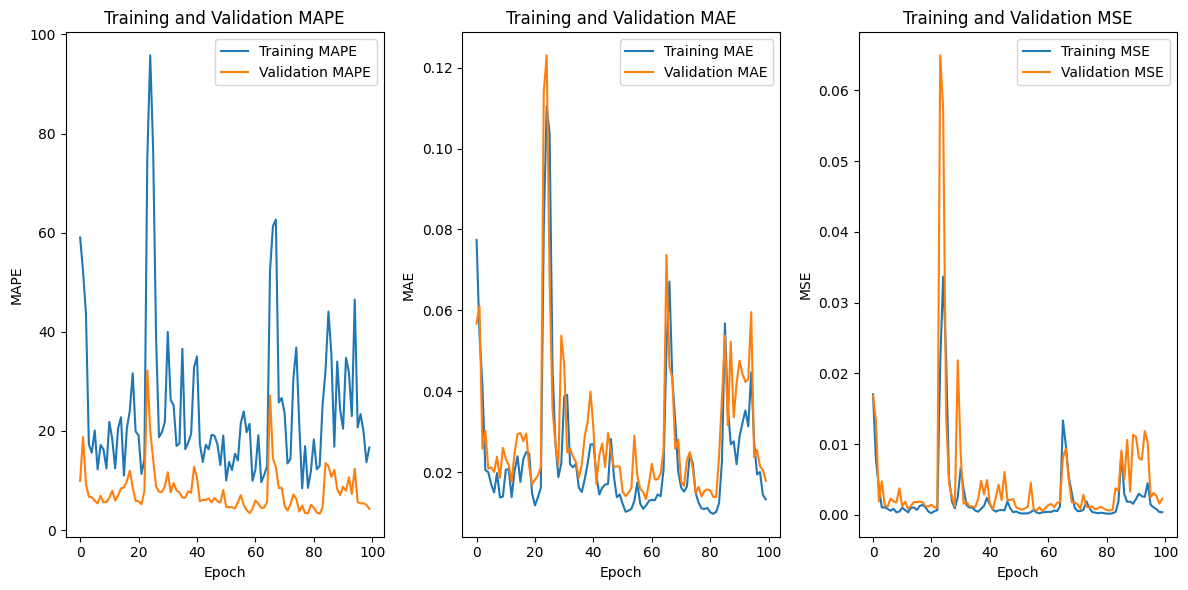

In [143]:
# Evaluate model on the test set
evaluation_results = model.evaluate(X_test_scaled, y_test_scaled)
accuracy, mae, mse, mape = evaluation_results[0], evaluation_results[1], evaluation_results[2], evaluation_results[3]

print(f'Loss on Test Set: {accuracy}')
print(f'Mean Absolute Error (MAE) on Test Set: {mae}')
print(f'Mean Squared Error (MSE) on Test Set: {mse}')
print(f'Mean Absolute Percentage Error (MAPE) on Test Set: {mape}')

# Plot training and validation metrics
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['mape'], label='Training MAPE')
plt.plot(history.history['val_mape'], label='Validation MAPE')
plt.xlabel('Epoch')
plt.ylabel('MAPE')
plt.title('Training and Validation MAPE')
plt.legend()

# Plot Mean Absolute Error (MAE)
plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()

# Plot Mean Squared Error (MSE)
plt.subplot(1, 3, 3)
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and Validation MSE')
plt.legend()

plt.tight_layout()
plt.show()


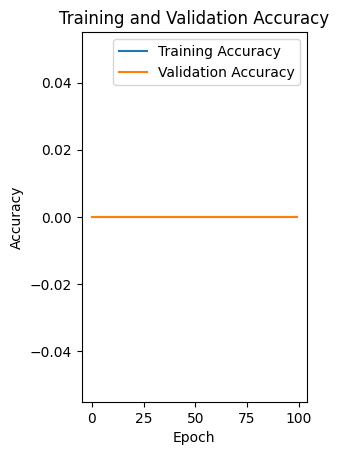

In [144]:
    # Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

Root mean squared error

In [136]:
 # Evaluate model on test set with Root Mean Squared Error
predictions = model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_scaler.inverse_transform(
        y_test_scaled), y_scaler.inverse_transform(predictions)))
print(f'Root Mean Squared Error on Test Set: {rmse}')

# Calculate the range of actual values NOT SURE THIS IS THE BEST WAY TO DO IT, COME BACK ON THIS.
actual_values = y_scaler.inverse_transform(y_test_scaled)
value_range = np.max(actual_values) - np.min(actual_values) 
# Normalize RMSE by dividing by the range
normalized_rmse = rmse / value_range

print(f'Root Mean Squared Error on Test Set: {rmse}')
print(f'Normalized RMSE on Test Set: {normalized_rmse}')

5/5 [==============================] - 0s 592us/step
Root Mean Squared Error on Test Set: 40215.05583495282
Root Mean Squared Error on Test Set: 40215.05583495282
Normalized RMSE on Test Set: 0.0034647581218742764


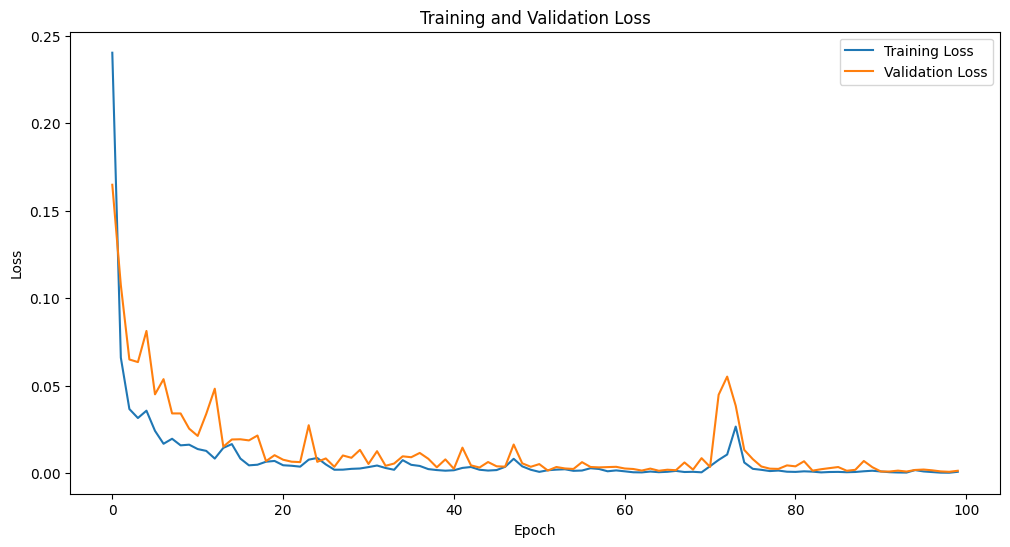

In [137]:
    # Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.plot(history.history['loss'][:], label='Training Loss')
plt.plot(history.history['val_loss'][:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

## Additionnal performance metrics

In [145]:
predictions = model.predict(X_test_scaled)
original_predictions = y_scaler.inverse_transform(predictions)
original_y_test = y_scaler.inverse_transform(y_test_scaled)

# performance metrics for regression
mae = mean_absolute_error(original_y_test, original_predictions)
mse = mean_squared_error(original_y_test, original_predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((original_y_test - original_predictions) / original_y_test)) * 100
r2 = r2_score(original_y_test, original_predictions)
evs = explained_variance_score(original_y_test, original_predictions)
max_err = max_error(original_y_test, original_predictions)
msle = mean_squared_log_error(original_y_test, original_predictions)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'R-squared (R^2): {r2}')
print(f'Explained Variance Score (EVS): {evs}')
print(f'Max Error: {max_err}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle}')


5/5 [==============================] - 0s 666us/step
Mean Absolute Error (MAE): 28164.18236159224
Mean Squared Error (MSE): 1699585465.2053835
Root Mean Squared Error (RMSE): 41226.02897691437
Mean Absolute Percentage Error (MAPE): 1.5161962230205075
R-squared (R^2): 0.9996162629137247
Explained Variance Score (EVS): 0.9996208666920158
Max Error: 222186.19121254422
Mean Squared Logarithmic Error (MSLE): 0.0004215915981843102
